* Comparing the stop criterion of precision is the goal with the enhanced version
* Describing the risk version

# Setup

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import beta

from utils_stats import (
    #hdi_ci_limits,
    successes_failures_to_hdi_ci_limits
)

from utils_viz import (
    #plot_success_rates
    plot_vhlines_lines,
    #plot_parity_line,
)

seed = 7

In [3]:

import matplotlib.pyplot as plt
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

FIG_WIDTH, FIG_HEIGHT = 8, 6

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = FIG_WIDTH, FIG_HEIGHT
# plt.rcParams["hatch.linewidth"] = 0.2

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Data

Experiments each containing many Bernoulli trials

In [4]:
success_rate_null = 0.5   # this is the null hypothesis, not necessarilly true
dsuccess_rate = 0.05 #success_rate * 0.1
rope_precision_fraction = 0.8

success_rate = 0.5  #0.65  #0.5 + 0.5 * dsuccess_rate  # the true value
# --------

rope_min = success_rate_null - dsuccess_rate
rope_max = success_rate_null + dsuccess_rate

# hypothesis: if precision_goal is lower, then PitG has less of
# an inconclusiveness problem but at the expense of more trials.
precision_goal = (2 * dsuccess_rate) * rope_precision_fraction
#precision_goal = (dsuccess_rate) * rope_precision_fraction # 1500 was not enough for 0.04
#precision_goal = (1.5 * dsuccess_rate) * rope_precision_fraction # 1500 was not enough for 0.04


print(f"{success_rate_null:0.5}: null")
print(f"{rope_min:0.2}: ROPE min")
print(f"{rope_max:0.2}: ROPE max")
print("-" * 20)
print(f"{precision_goal:0.2}: Precision Goal")
print("-" * 20)
print(f"{success_rate:0.3}: true")

0.5: null
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal
--------------------
0.5: true


In [5]:
experiments = 500 # number of experiments 500 #200 #300 #200
n_samples = 1500  #2500 # max number of samples in each experiement #2500 #1000 #1500

np.random.seed(seed)
samples = np.random.binomial(1, success_rate, [experiments, n_samples])

samples.shape  # (experiments, n_samples)

(500, 1500)

# Enhanced Precision is the Goal

As compared to "Precision is the Goal" and HDI+ROPE.

In [6]:
dict_successes_failures_hdi_limits = {}
dict_successes_failures_counter = {}

def _update_iteration_tally(iteration_dict, iteration):
    for this_iteration in range(iteration, len(iteration_dict)+1):
        iteration_dict[this_iteration] += 1

def booleans_to_rope_result(decision_accept, decision_reject_below, decision_reject_above):
    if decision_accept:
        return "within"
    elif decision_reject_below:
        return "below"
    elif decision_reject_above:
        return "above"

def successes_failures_to_hdi_limits(successes, failures):

    pair = (successes, failures)
    if pair not in dict_successes_failures_hdi_limits:
        dict_successes_failures_hdi_limits[pair] =\
            successes_failures_caculate_hdi_limits(successes, failures)
        dict_successes_failures_counter[pair] = 1
    else:
        dict_successes_failures_counter[pair] += 1

    return dict_successes_failures_hdi_limits[pair]


def successes_failures_caculate_hdi_limits(successes, failures):
    aa = int(successes)
    bb = int(failures)
    
    if not failures:
        aa += 1
        bb += 1
        
    if not successes:
        aa += 1
        bb += 1

    hdi_min, hdi_max = successes_failures_to_hdi_ci_limits(aa, bb)

    return hdi_min, hdi_max

In [80]:
# For each method and rope result type creating tally of outcomes

method_roperesult_iteration = {}
methods = ["pitg", "epitg", "hdi_rope"]
rope_results = ["within", "below", "above"]
for method in methods:
    method_roperesult_iteration[method] = {}
    for rope_result in rope_results:
        method_roperesult_iteration[method][rope_result] = {iteration: 0 for iteration in range(1, n_samples + 1)}

print(method, rope_result)
len(method_roperesult_iteration[method][rope_result])

hdi_rope above


1500

In [81]:
iteration_number = np.arange(1, n_samples + 1)

method_stats = {"pitg": {}, "epitg": {}, "hdi_rope": {}}

for isample, sample in enumerate(samples):
    pitg_stopped = False
    hdi_rope_stopped = False

    iteration_successes = sample.cumsum()
    iteration_failures = iteration_number - iteration_successes

    for iteration, successes, failures in zip(iteration_number, iteration_successes, iteration_failures):
        final_iteration = iteration == iteration_number[-1]
        hdi_min, hdi_max = successes_failures_to_hdi_limits(successes, failures)
        #hdi_min, hdi_max = successes_failures_caculate_hdi_limits(successes, failures)

        # has the precision goal been achieved?
        precision_goal_achieved = (hdi_max - hdi_min) < precision_goal

        # is the HDI conclusively within or outside the ROPE?
        decision_accept = (hdi_min >= rope_min) & (hdi_max <= rope_max)
        decision_reject_below = hdi_max < rope_min  
        decision_reject_above = rope_max < hdi_min
        conclusive = decision_accept | decision_reject_above | decision_reject_below

        iteration_results = {"decision_iteration": iteration,
                                                 "accept": decision_accept,
                                                    "reject_below": decision_reject_below,
                                                    "reject_above": decision_reject_above,
                                                    "conclusive": conclusive,
                                                    "inconclusive": not conclusive,
                                                    "successes": successes,
                                                    "failures": failures,
                                                    "hdi_min": hdi_min,
                                                    "hdi_max": hdi_max,
                                                 }   

        if precision_goal_achieved:

            # update Precision Is The Goal Stop
            if pitg_stopped is False:
                # not applying `break` because we continue for ePiTG
                if conclusive:
                    rope_result = booleans_to_rope_result(decision_accept, decision_reject_below, decision_reject_above)
                    _update_iteration_tally(method_roperesult_iteration["pitg"][rope_result], iteration)
                method_stats["pitg"][isample] = iteration_results
                pitg_stopped = True  # sample does not continue with PITG (only ePiTG) 

            # continue with Enhance Precision Is The Goal
            if conclusive:
                rope_result = booleans_to_rope_result(decision_accept, decision_reject_below, decision_reject_above)
                _update_iteration_tally(method_roperesult_iteration["epitg"][rope_result], iteration)

                if hdi_rope_stopped is False:
                    _update_iteration_tally(method_roperesult_iteration["hdi_rope"][rope_result], iteration)
                    
            if conclusive | final_iteration:
                method_stats["epitg"][isample] = iteration_results

                if hdi_rope_stopped is False:
                    method_stats["hdi_rope"][isample] = iteration_results
                    hdi_rope_stopped = True

                if final_iteration:
                    print(f"Sample {isample} at final iteration")
                    print(method_stats["epitg"][isample])
                break
        
        elif conclusive & (hdi_rope_stopped is False):
            # case in which precision not achieved yet but conclusive.
            # this is the HDI+ROPE approach which disregards precision
            rope_result = booleans_to_rope_result(decision_accept, decision_reject_below, decision_reject_above)
            _update_iteration_tally(method_roperesult_iteration["hdi_rope"][rope_result], iteration)
            method_stats["hdi_rope"][isample] = iteration_results

            hdi_rope_stopped = True

        elif final_iteration:
            # ensures that if reached final iteration and not conclusive that
            # results are still recorded as inconclusive
            
            """
            decision_accept = False
            decision_reject_below = False
            decision_reject_above = False
            conclusive = False
            """
            if isample not in method_stats["hdi_rope"]:
               method_stats["hdi_rope"][isample] = iteration_results
            if isample not in method_stats["pitg"]:
                method_stats["pitg"][isample] = iteration_results
            if isample not in method_stats["epitg"]:
                method_stats["epitg"][isample] = iteration_results
            break

Sample 140 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 708, 'failures': 792, 'hdi_min': 0.446766867411269, 'hdi_max': 0.4972694566161049}
Sample 165 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 809, 'failures': 691, 'hdi_min': 0.5141054692980911, 'hdi_max': 0.5645305410768443}
Sample 169 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 698, 'failures': 802, 'hdi_min': 0.4401126621762446, 'hdi_max': 0.4905728257358288}
Sample 171 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 705, 'failures': 795, 'hdi_min': 0.44

In [82]:
# examining uniqueness distributions of success and failure pairs
pd.Series(dict_successes_failures_counter).value_counts(normalize=True).sort_index()

1       0.011746
4       0.311258
5       0.000451
8       0.140292
9       0.000659
          ...   
784     0.000017
788     0.000017
896     0.000017
925     0.000017
1076    0.000017
Name: proportion, Length: 191, dtype: float64

In [83]:
def stats_dict_to_df(method_stats):
    df = pd.DataFrame(method_stats).T
    df.index.name = "experiment_number"
    df["precision"] = df["hdi_max"] - df["hdi_min"]
    df["success_rate"] = df["successes"] / (df["successes"] + df["failures"])
    return df


df_stats_epitg = stats_dict_to_df(method_stats["epitg"])
print(df_stats_epitg.shape)
df_stats_epitg.head(4)

(500, 12)


,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
experiment_number,,,,,,,,,,,,
0,760,True,False,False,True,False,369,391,0.450039,0.521038,0.070999,0.485526
1,599,True,False,False,True,False,299,300,0.459174,0.539161,0.079987,0.499165
2,794,True,False,False,True,False,409,385,0.48037,0.549832,0.069462,0.515113
3,599,True,False,False,True,False,295,304,0.452509,0.532487,0.079978,0.492487


In [84]:
df_stats_pitg = stats_dict_to_df(method_stats["pitg"])
print(df_stats_pitg.shape)
df_stats_pitg.head(4)

(500, 12)


,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
experiment_number,,,,,,,,,,,,
0,598,False,False,False,False,True,288,310,0.44161,0.521609,0.079999,0.481605
1,599,True,False,False,True,False,299,300,0.459174,0.539161,0.079987,0.499165
2,597,False,False,False,False,True,318,279,0.492653,0.572602,0.079949,0.532663
3,599,True,False,False,True,False,295,304,0.452509,0.532487,0.079978,0.492487


In [85]:
df_stats_hdirope = stats_dict_to_df(method_stats["hdi_rope"])
print(df_stats_hdirope.shape)
df_stats_hdirope.head(4)

(500, 12)


,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
experiment_number,,,,,,,,,,,,
0,424,True,False,False,True,False,211,213,0.45014,0.545164,0.095024,0.497642
1,443,True,False,False,True,False,223,220,0.456903,0.549872,0.092969,0.503386
2,794,True,False,False,True,False,409,385,0.48037,0.549832,0.069462,0.515113
3,597,True,False,False,True,False,293,304,0.450736,0.530843,0.080107,0.490787


In [86]:
df_stats_pitg.equals(df_stats_epitg)

False

In [87]:
def iteration_counts_to_df(roperesult_iteration, experiments):
    df = pd.DataFrame({
        "iteration": list(roperesult_iteration["within"].keys()),
        "accept": list(roperesult_iteration["within"].values()),
        "reject_below": list(roperesult_iteration["below"].values()),
        "reject_above": list(roperesult_iteration["above"].values())
    })

    df['reject'] = df['reject_above'] + df['reject_below']
    df['inconclusive'] = experiments - df['accept'] - df['reject']

    return df

df_pitg_counts = iteration_counts_to_df(method_roperesult_iteration["pitg"], experiments)
df_epitg_counts = iteration_counts_to_df(method_roperesult_iteration["epitg"], experiments)
df_hdirope_counts = iteration_counts_to_df(method_roperesult_iteration["hdi_rope"], experiments)


df_epitg_counts.head(4)

,iteration,accept,reject_below,reject_above,reject,inconclusive
0,1,0,0,0,0,500
1,2,0,0,0,0,500
2,3,0,0,0,0,500
3,4,0,0,0,0,500


In [88]:
df_epitg_counts.describe()

,iteration,accept,reject_below,reject_above,reject,inconclusive
count,1500.000000,1500.000000,1500.0,1500.0,1500.0,1500.000000
mean,750.500000,246.762667,0.0,0.0,0.0,253.237333
std,433.157015,209.758490,0.0,0.0,0.0,209.758490
min,1.000000,0.000000,0.0,0.0,0.0,13.000000
25%,375.750000,0.000000,0.0,0.0,0.0,48.000000
50%,750.500000,319.500000,0.0,0.0,0.0,180.500000
75%,1125.250000,452.000000,0.0,0.0,0.0,500.000000
max,1500.000000,487.000000,0.0,0.0,0.0,500.000000


In [89]:
df_pitg_counts.describe()

,iteration,accept,reject_below,reject_above,reject,inconclusive
count,1500.000000,1500.000000,1500.0,1500.0,1500.0,1500.000000
mean,750.500000,105.834667,0.0,0.0,0.0,394.165333
std,433.157015,86.202544,0.0,0.0,0.0,86.202544
min,1.000000,0.000000,0.0,0.0,0.0,324.000000
25%,375.750000,0.000000,0.0,0.0,0.0,324.000000
50%,750.500000,176.000000,0.0,0.0,0.0,324.000000
75%,1125.250000,176.000000,0.0,0.0,0.0,500.000000
max,1500.000000,176.000000,0.0,0.0,0.0,500.000000


In [90]:
df_hdirope_counts.describe()

,iteration,accept,reject_below,reject_above,reject,inconclusive
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,750.500000,214.044667,61.306000,58.418667,119.724667,166.230667
std,433.157015,145.826073,4.198585,3.859877,8.048854,147.906553
min,1.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,375.750000,0.000000,62.000000,59.000000,121.000000,32.000000
50%,750.500000,261.000000,62.000000,59.000000,121.000000,118.000000
75%,1125.250000,347.000000,62.000000,59.000000,121.000000,379.000000
max,1500.000000,373.000000,62.000000,59.000000,121.000000,500.000000


In [91]:
df_pitg_counts.equals(df_epitg_counts)

False

Text(0.5, 1.0, 'true success rate = 0.500')

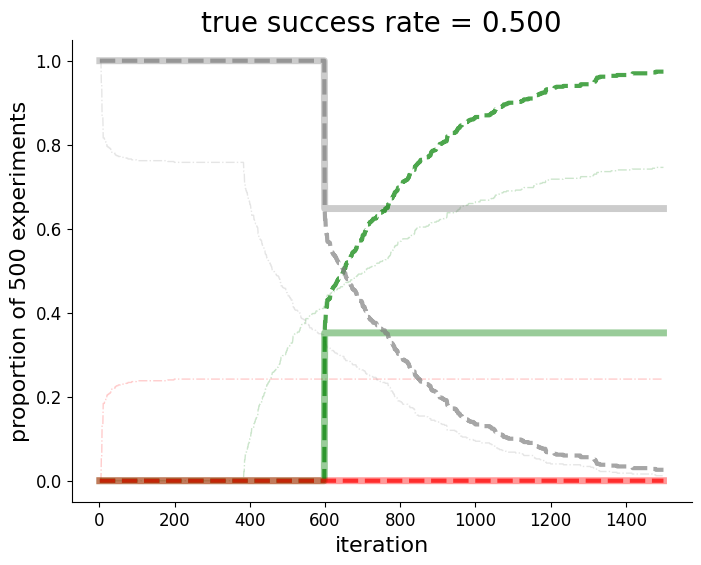

In [92]:
title = f"true success rate = {success_rate:0.3f}"
xlabel = "iteration"

iteration_values = df_pitg_counts["iteration"]

# plotting HDI+ROPE
alpha, linewidth, linestyle = 0.2, 1, "-."
plt.plot(iteration_values, df_hdirope_counts['accept'] / experiments, color="green", linewidth=linewidth, alpha=alpha, linestyle=linestyle)
plt.plot(iteration_values, df_hdirope_counts['reject'] / experiments, color="red", linewidth=linewidth, alpha=alpha, linestyle=linestyle)
plt.plot(iteration_values, df_hdirope_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth, alpha=alpha, linestyle=linestyle)


# plotting pitg
alpha, linewidth = 0.4, 5
plt.plot(iteration_values, df_pitg_counts['accept'] / experiments, color="green", linewidth=linewidth, alpha=alpha)
plt.plot(iteration_values, df_pitg_counts['reject'] / experiments, color="red", linewidth=linewidth, alpha=alpha)
plt.plot(iteration_values, df_pitg_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth, alpha=alpha)

# plotting epitg
alpha, linewidth, linestyle = 0.7, 3, "--"
plt.plot(iteration_values, df_epitg_counts['accept'] / experiments, color="green", linewidth=linewidth, alpha=alpha, linestyle=linestyle)
plt.plot(iteration_values, df_epitg_counts['reject'] / experiments, color="red", linewidth=linewidth, alpha=alpha, linestyle=linestyle)
plt.plot(iteration_values, df_epitg_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth, alpha=alpha, linestyle=linestyle)


#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(xlabel)
plt.ylabel(f"proportion of {experiments:,} experiments")
plt.title(title)

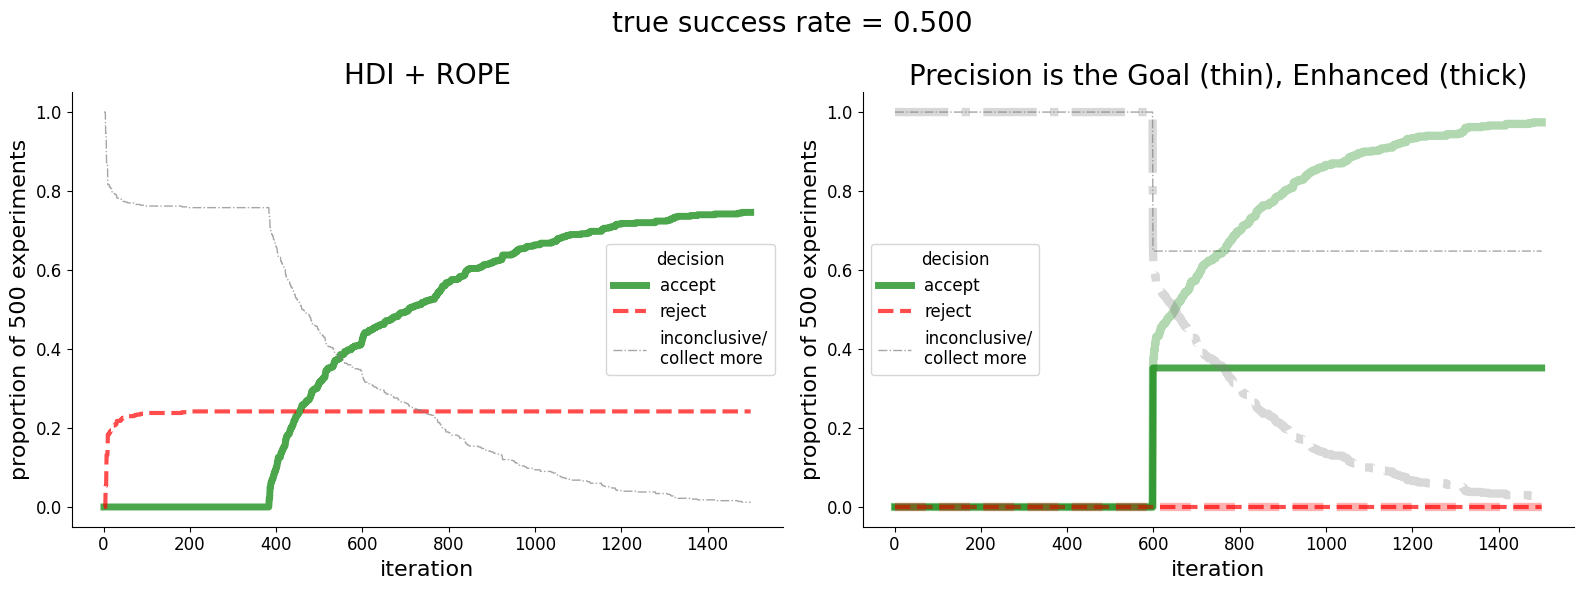

In [93]:
plt.figure(figsize=(FIG_WIDTH * 2, FIG_HEIGHT))

viz_epitg = True

suptitle = f"true success rate = {success_rate:0.3f}"
alpha=0.7

linestyle_accept, linewidth_accept = None, 5
linestyle_reject, linewidth_reject = "--", 3
linestyle_inconclusive, linewidth_inconclusive = "-.", 1


plt.subplot(1, 2, 1)

# plotting HDI+ROPE
plt.plot(iteration_values, df_hdirope_counts['accept'] / experiments, color="green", linewidth=linewidth_accept, alpha=alpha, linestyle=linestyle_accept, label="accept")
plt.plot(iteration_values, df_hdirope_counts['reject'] / experiments, color="red", linewidth=linewidth_reject, alpha=alpha, linestyle=linestyle_reject, label="reject")
plt.plot(iteration_values, df_hdirope_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth_inconclusive, alpha=alpha, linestyle=linestyle_inconclusive, label="inconclusive/\ncollect more")

plt.legend(title="decision")
plt.xlabel(xlabel)
plt.ylabel(f"proportion of {experiments:,} experiments")
plt.title("HDI + ROPE")


plt.subplot(1, 2, 2)

# plotting PitG
plt.plot(iteration_values, df_pitg_counts['accept'] / experiments, color="green", linewidth=linewidth_accept, alpha=alpha, linestyle=linestyle_accept, label="accept")
plt.plot(iteration_values, df_pitg_counts['reject'] / experiments, color="red", linewidth=linewidth_reject, alpha=alpha, linestyle=linestyle_reject, label="reject")
plt.plot(iteration_values, df_pitg_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth_inconclusive, alpha=alpha, linestyle=linestyle_inconclusive, label="inconclusive/\ncollect more")

if viz_epitg:
    linewidth_epitg, alpha_epitg = 6, 0.3
    plt.plot(iteration_values, df_epitg_counts['accept'] / experiments, color="green", linewidth=linewidth_epitg, alpha=alpha_epitg, linestyle=linestyle_accept, label=None)
    plt.plot(iteration_values, df_epitg_counts['reject'] / experiments, color="red", linewidth=linewidth_epitg, alpha=alpha_epitg, linestyle=linestyle_reject, label=None)
    plt.plot(iteration_values, df_epitg_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth_epitg, alpha=alpha_epitg, linestyle=linestyle_inconclusive, label=None)
    plt.title("Precision is the Goal (thin), Enhanced (thick)")
else:
    plt.title("Precision is the Goal")


plt.legend(title="decision")
plt.xlabel(xlabel)
plt.ylabel(f"proportion of {experiments:,} experiments")


plt.suptitle(suptitle, fontsize=20)
plt.tight_layout()

In [94]:
df_hdirope_counts.drop(["iteration", "reject"], axis=1).sum(axis=1).value_counts()

500    1500
Name: count, dtype: int64

In [95]:
import seaborn as sns

df_plot = df_stats_hdirope[["decision_iteration", "success_rate"]]
df_plot["method"] = "HDI + ROPE"
df_append = df_stats_pitg[["decision_iteration", "success_rate"]]
df_append["method"] = "PitG"
df_plot = pd.concat([df_plot, df_append])
df_append = df_stats_epitg[["decision_iteration", "success_rate"]]
df_append["method"] = "ePiTG"
df_plot = pd.concat([df_plot, df_append])

/var/folders/tk/pqpnl5fj477b2zpg4s7qj9300000gq/T/ipykernel_28966/3214399852.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["method"] = "HDI + ROPE"
/var/folders/tk/pqpnl5fj477b2zpg4s7qj9300000gq/T/ipykernel_28966/3214399852.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_append["method"] = "PitG"
/var/folders/tk/pqpnl5fj477b2zpg4s7qj9300000gq/T/ipykernel_28966/3214399852.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

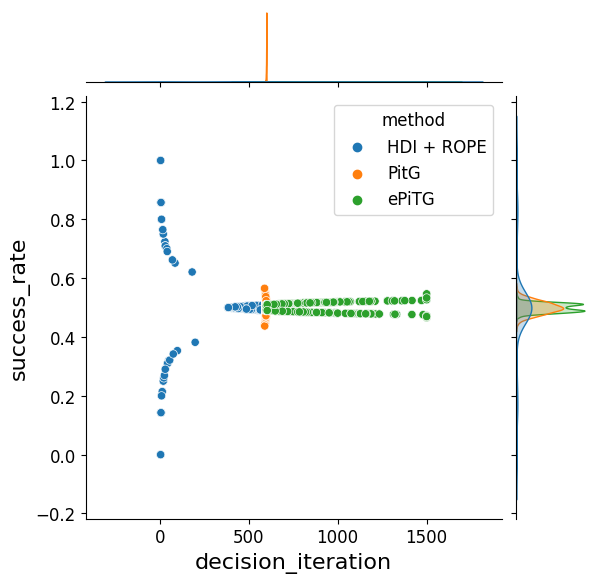

In [96]:
sns.jointplot(x=df_plot["decision_iteration"], y=df_plot["success_rate"], color="#4CB391", hue=df_plot["method"])

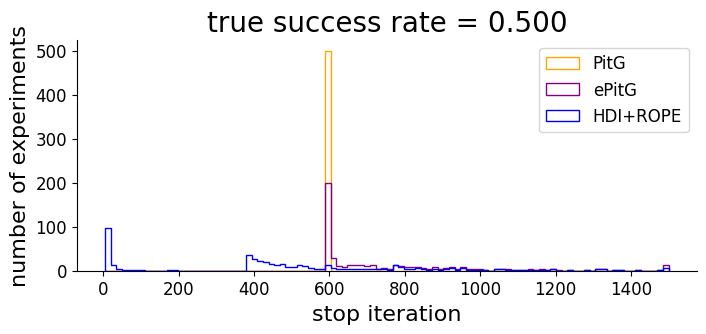

In [97]:
plt.figure(figsize=(FIG_WIDTH, 0.5 * FIG_HEIGHT))

all_values = np.concatenate([df_stats_epitg["decision_iteration"], df_stats_pitg["decision_iteration"], df_stats_hdirope["decision_iteration"] ])

_, bins = np.histogram(all_values, bins=100)

plt.hist(df_stats_pitg["decision_iteration"], bins=bins, histtype='step', label="PitG", color="orange")
plt.hist(df_stats_epitg["decision_iteration"], bins=bins, histtype='step', label="ePitG", color="purple")   
plt.hist(df_stats_hdirope["decision_iteration"], bins=bins, histtype='step', label="HDI+ROPE", color="blue")   
plt.xlabel("stop iteration")
plt.ylabel("number of experiments")
plt.legend()
plt.title(title)
pass

In [138]:
# TODO: rope_min, rope_max are not defined
def plot_pdf(sr_experiment_stats, xlim=None):
    pp = np.linspace(0, 1, 1000)
    pp_hdi = np.linspace(sr_experiment_stats["hdi_min"], sr_experiment_stats["hdi_max"], 1000)

    successes = sr_experiment_stats["successes"]
    failures = sr_experiment_stats["failures"]
    rate = successes / (successes + failures)
    n_ = successes + failures
    hdi_min, hdi_max = successes_failures_to_hdi_limits(successes, failures)

    pdf = beta.pdf(pp, successes, failures)
    pdf_hdi = beta.pdf(pp_hdi, successes, failures)

    plt.plot(pp, pdf, color="purple", label=f"pdf p={rate:0.3f}; n={n_:,}")
    label_hdi = f"HDI Δ={hdi_max - hdi_min:0.3f}"
    plt.fill_between(pp_hdi, pdf_hdi, color="purple", alpha=0.2, label=label_hdi)
    plot_vhlines_lines(vertical=rope_min, label='ROPE', horizontal=None)
    plot_vhlines_lines(vertical=rope_max, horizontal=None)
    plt.legend()
    plt.xlabel("success rate")
    plt.ylabel("probability density")

    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim([rope_min - 0.1, rope_max + 0.1])

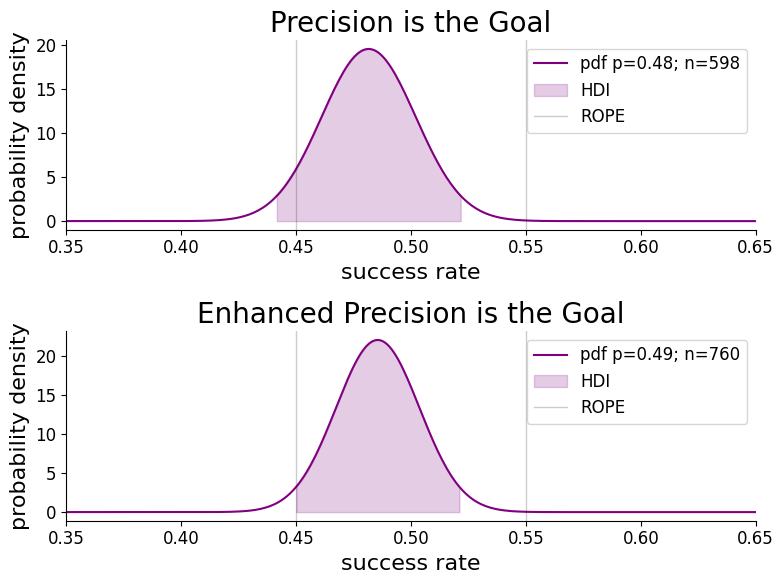

In [99]:
# experiment with the latest iteration
#idx = df_stats_epitg["decision_iteration"].astype(float).argmax()


# pitg inconclusive
#idx = df_stats_pitg.query("inconclusive").index[0]
idx = df_stats_pitg.index[0]

# ---
sr_experiment_stats_pitg = df_stats_pitg.loc[idx]
sr_experiment_stats_epitg = df_stats_epitg.loc[idx]

fig, axs = plt.subplots(2, 1, figsize=(FIG_WIDTH, FIG_HEIGHT))

plt.subplot(2, 1, 1)
plot_pdf(sr_experiment_stats_pitg) #, xlim=(0.4,1))
plt.title("Precision is the Goal")

plt.subplot(2, 1, 2)
plt.title("Enhanced Precision is the Goal")
plot_pdf(sr_experiment_stats_epitg) #, xlim=(0.4,1))
plt.tight_layout()

In [100]:
df_stats_pitg.astype(float).describe()

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
count,500.000000,500.000000,500.0,500.0,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,598.088000,0.352000,0.0,0.0,0.352000,0.648000,299.002000,299.086000,0.459944,0.539917,0.079973,0.499931
std,1.457568,0.478072,0.0,0.0,0.478072,0.478072,12.907021,12.927523,0.021614,0.021613,0.000017,0.021633
min,589.000000,0.000000,0.0,0.0,0.000000,0.000000,258.000000,256.000000,0.397377,0.477331,0.079919,0.437288
25%,598.000000,0.000000,0.0,0.0,0.000000,0.000000,291.000000,291.000000,0.445850,0.525805,0.079962,0.485810
50%,599.000000,0.000000,0.0,0.0,0.000000,1.000000,299.000000,300.000000,0.459174,0.539161,0.079978,0.499165
75%,599.000000,1.000000,0.0,0.0,1.000000,1.000000,308.000000,308.000000,0.474195,0.554150,0.079986,0.514190
max,599.000000,1.000000,0.0,0.0,1.000000,1.000000,333.000000,332.000000,0.525308,0.605274,0.079999,0.565365


Text(0.5, 0, 'success rate at stop')

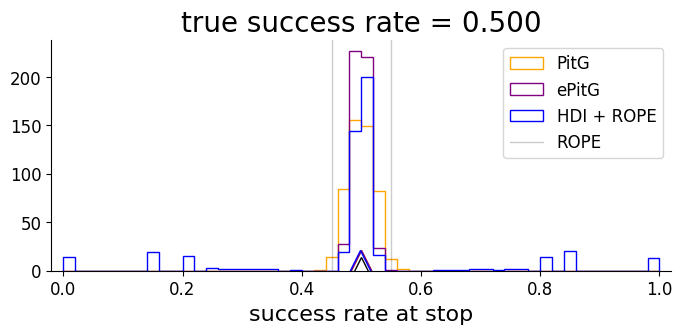

In [101]:
plt.figure(figsize=(FIG_WIDTH, 0.5 * FIG_HEIGHT))

all_values = np.concatenate([df_stats_epitg["success_rate"], df_stats_pitg["success_rate"], df_stats_hdirope["success_rate"]])
_, bins = np.histogram(all_values, bins=50)

plt.hist(df_stats_pitg["success_rate"], bins=bins, histtype='step', label="PitG", color="orange")
plt.hist(df_stats_epitg["success_rate"], bins=bins, histtype='step', label="ePitG", color="purple")
plt.hist(df_stats_hdirope["success_rate"], bins=bins, histtype='step', label="HDI + ROPE", color="blue")


# marker of truth
marker_style = dict(color='black', linestyle=':', marker='^',
                    markersize=20, markerfacecoloralt='tab:black')
plt.plot([success_rate], [0], fillstyle='none' , **marker_style)

plot_vhlines_lines(vertical=rope_min, label='ROPE', horizontal=None)
plot_vhlines_lines(vertical=rope_max, horizontal=None)

# marker of pitg
marker_style = dict(color='orange', linestyle='--', marker='^',
                    markersize=30, markerfacecoloralt='tab:orange')
plt.plot([df_stats_pitg["success_rate"].mean()], [0], **marker_style, fillstyle='none')

# marker of epitg
marker_style = dict(color='purple', linestyle=':', marker='^',
                   markersize=30, markerfacecoloralt='tab:purple')
plt.plot([df_stats_epitg["success_rate"].mean()], [0], **marker_style, fillstyle='none')

# marker of hdi+rope
marker_style = dict(color='blue', linestyle=':', marker='^',
                    markersize=30, markerfacecoloralt='tab:blue')
plt.plot([df_stats_hdirope["success_rate"].mean()], [0], **marker_style, fillstyle='none')

plt.legend()

xlim = [np.min([rope_min, all_values.min()]), np.max([rope_max, all_values.max()])]
plt.xlim([xlim[0] - 0.02, xlim[1] + 0.02])
plt.title(title)
plt.xlabel("success rate at stop")

(0.4, 0.6)

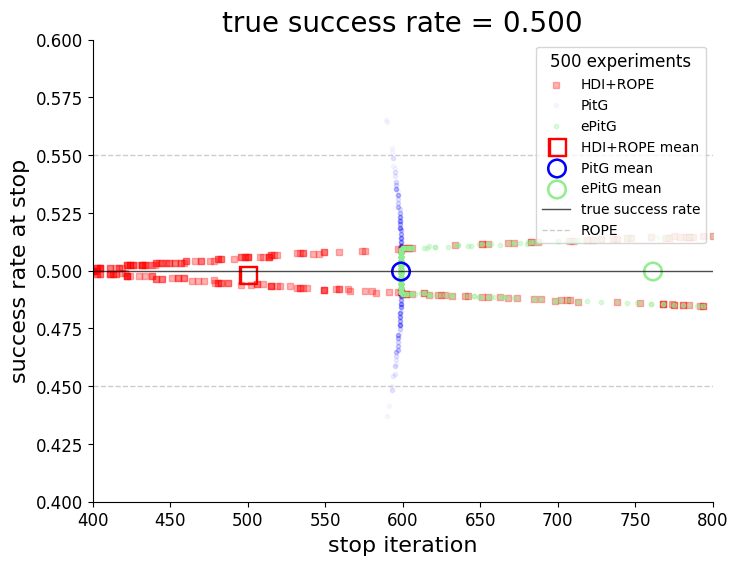

In [119]:
plt.scatter(df_stats_hdirope["decision_iteration"], df_stats_hdirope["success_rate"], alpha=0.3, color="red", label="HDI+ROPE", marker="s", s=20)
plt.scatter(df_stats_pitg["decision_iteration"], df_stats_pitg["success_rate"], alpha=0.03, color="blue", label="PitG", marker=".")
plt.scatter(df_stats_epitg["decision_iteration"], df_stats_epitg["success_rate"], alpha=0.3, color="lightgreen", label="ePitG", marker="o", s=10)


plt.scatter(df_stats_hdirope["decision_iteration"].mean(), df_stats_hdirope["success_rate"].mean(), color="red", label="HDI+ROPE mean", s=200, marker="$\u25A1$")
plt.scatter(df_stats_pitg["decision_iteration"].mean(), df_stats_pitg["success_rate"].mean(), color="blue", label="PitG mean", s=200, marker="$\u25EF$")
plt.scatter(df_stats_epitg["decision_iteration"].mean(), df_stats_epitg["success_rate"].mean(), color="lightgreen", label="ePitG mean", s=200, marker="$\u25EF$")



plot_vhlines_lines(vertical=None, label='true success rate', horizontal=success_rate, alpha=0.7)

plot_vhlines_lines(vertical=None, label='ROPE', horizontal=rope_min, linestyle="--")
plot_vhlines_lines(vertical=None, horizontal=rope_max, linestyle="--")
plt.xlabel("stop iteration")
plt.ylabel("success rate at stop")

plt.legend(title=f"{len(df_stats_pitg):,} experiments", loc="upper right", fontsize=10)
plt.title(title)
plt.xlim(400, 800)
plt.ylim(0.4, 0.6)

In [50]:
(df_stats_hdirope.query("conclusive")["reject_below"] + df_stats_hdirope.query("conclusive")["reject_above"]).astype(float).sum() / len(df_stats_hdirope.query("conclusive"))

0.36890243902439024

In [ ]:
df_stats_hdirope.query(f"hdi_min > {success_rate-0.1}").sort_values("hdi_min")

In [ ]:
df_stats_hdirope["stop_success_rate"] = df_stats_hdirope["successes"] / df_stats_hdirope["decision_iteration"]

In [ ]:
df_stats_hdirope.sort_values("stop_success_rate", ascending=False).head(20)

In [ ]:
df_stats_hdirope.query("reject_above").head(20)

In [ ]:
df_stats_epitg.sort_values("decision_iteration", ascending=False)

In [121]:
df_stats_pitg["inconclusive"].value_counts()/ len(df_stats_pitg)

inconclusive
True     0.648
False    0.352
Name: count, dtype: float64

In [120]:
df_stats_epitg["inconclusive"].value_counts()/ len(df_stats_pitg)

inconclusive
False    0.974
True     0.026
Name: count, dtype: float64

In [224]:
df_stats_hdirope

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
experiment_number,,,,,,,,,,,,
0,424,True,False,False,True,False,211,213,0.45014,0.545164,0.095024,0.497642
1,443,True,False,False,True,False,223,220,0.456903,0.549872,0.092969,0.503386
2,794,True,False,False,True,False,409,385,0.48037,0.549832,0.069462,0.515113
3,597,True,False,False,True,False,293,304,0.450736,0.530843,0.080107,0.490787
4,445,True,False,False,True,False,224,221,0.456992,0.549753,0.092761,0.503371
...,...,...,...,...,...,...,...,...,...,...,...,...
495,1157,True,False,False,True,False,554,603,0.450073,0.507607,0.057534,0.478825
496,1075,True,False,False,True,False,516,559,0.450169,0.50986,0.059691,0.48
497,845,True,False,False,True,False,436,409,0.482297,0.54963,0.067334,0.515976


In [287]:
# In draft using isample= 179 of success_rate = 0.5
# potential isample=203 - hdi+rope 99 , epitg >1,300
# potential isample=221  - hdi+rope 31, epitg 886
# potential isample=294
# potential isample=333

#isample = 2
#isample=44
#isample = 179 # found via df_stats_hdirope.query("reject_above").head(20) #8 
#isample = df_stats_hdirope.query("(reject_above) | (reject_below) ").query("decision_iteration > 50").index[3]
#isample = 250 # found via df_stats_epitg.sort_values("decision_iteration", ascending=False)
#isample = 353


isamples_subset = list(sorted(set(df_stats_hdirope.query("(reject_above) | (reject_below) ").query("decision_iteration > 20").index) & set(df_stats_pitg.query("inconclusive").index) & set(df_stats_epitg.query("conclusive").index)))
isample = isamples_subset[8]

print(isample)

sample = samples[isample]
iteration_successes = sample.cumsum()
iteration_failures = iteration_number - iteration_successes

sample_results = {}
for iteration, successes, failures in zip(iteration_number, iteration_successes, iteration_failures):
    final_iteration = iteration == iteration_number[-1]
    hdi_min, hdi_max = successes_failures_to_hdi_limits(successes, failures)
    #hdi_min, hdi_max = successes_failures_caculate_hdi_limits(successes, failures)

    # has the precision goal been achieved?
    precision_goal_achieved = (hdi_max - hdi_min) < precision_goal

    # is the HDI conclusively within or outside the ROPE?
    decision_accept = (hdi_min >= rope_min) & (hdi_max <= rope_max)
    decision_reject_below = hdi_max < rope_min  
    decision_reject_above = rope_max < hdi_min
    conclusive = decision_accept | decision_reject_above | decision_reject_below


    iteration_results = {"decision_iteration": iteration,
                                                "accept": decision_accept,
                                                "reject_below": decision_reject_below,
                                                "reject_above": decision_reject_above,
                                                "conclusive": conclusive,
                                                "inconclusive": not conclusive,
                                                "successes": successes,
                                                "failures": failures,
                                                "hdi_min": hdi_min,
                                                "hdi_max": hdi_max,
                                                "goal_achieved": precision_goal_achieved,
                                                }   

    sample_results[iteration] = iteration_results

338


In [288]:
df_sample_results = pd.DataFrame(sample_results).T
df_sample_results["hdi_max"] = df_sample_results["hdi_max"].astype(float)
df_sample_results["hdi_min"] = df_sample_results["hdi_min"].astype(float)
df_sample_results["decision_iteration"] = df_sample_results["decision_iteration"].astype(float)

df_sample_conclusive = df_sample_results.query("conclusive")
display(df_sample_conclusive.head(4))

df_sample_goal = df_sample_results.query("goal_achieved")
display(df_sample_goal.head(4))

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,goal_achieved
26,26.0,False,True,False,True,False,7,19,0.110589,0.437728,False
31,31.0,False,True,False,True,False,9,22,0.139331,0.448781,False
32,32.0,False,True,False,True,False,9,23,0.134180,0.435892,False
33,33.0,False,True,False,True,False,9,24,0.129421,0.423735,False


,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,goal_achieved
598,598.0,False,False,False,False,True,286,312,0.438287,0.518264,True
599,599.0,False,False,False,False,True,287,312,0.439199,0.519116,True
600,600.0,False,False,False,False,True,287,313,0.438425,0.518270,True
601,601.0,False,False,False,False,True,288,313,0.439334,0.519119,True


In [289]:
df_sample_goal.query("conclusive").head(4)

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,goal_achieved
1055,1055.0,True,False,False,True,False,507,548,0.450455,0.510711,True
1056,1056.0,True,False,False,True,False,507,549,0.450016,0.510241,True
1057,1057.0,True,False,False,True,False,508,549,0.450520,0.510719,True
1058,1058.0,True,False,False,True,False,508,550,0.450082,0.510251,True


Text(0.5, 1.0, 'true success rate = 0.500')

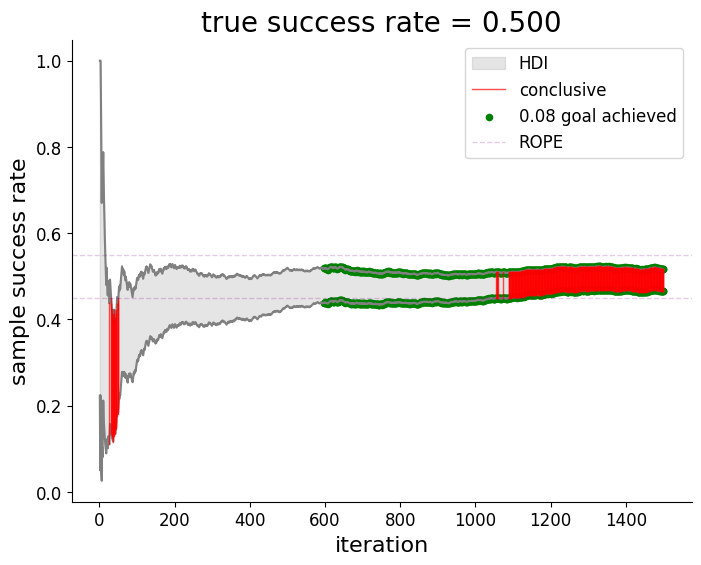

In [290]:
# In draft using isample= 179 of success_rate = 0.5
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

plt.plot(df_sample_results["decision_iteration"], df_sample_results["hdi_min"], color="gray", label=None)
plt.plot(df_sample_results["decision_iteration"], df_sample_results["hdi_max"], color="gray", label=None)
plt.fill_between(df_sample_results["decision_iteration"], df_sample_results["hdi_max"], df_sample_results["hdi_min"], color='gray', alpha=0.2, label="HDI")

for idx, (iteration, row) in enumerate(df_sample_conclusive.iterrows()):
    if idx == 0:
        label = "conclusive"
    else:
        label = None
    plt.plot([iteration, iteration], [row['hdi_min'], row['hdi_max']], color='red', alpha=0.7, linewidth=1, label=label)

#for iteration, row in df_sample_goal.iterrows():
#    plt.plot([iteration, iteration], [row['hdi_min'], row['hdi_max']], color='blue', alpha=0.1, linewidth=1)
plt.scatter(df_sample_goal["decision_iteration"], df_sample_goal["hdi_min"], color="green", label=f"{precision_goal:0.3} goal achieved", marker="o", s=20)
plt.scatter(df_sample_goal["decision_iteration"], df_sample_goal["hdi_max"], color="green", label=None, marker="o", s=20)

plot_vhlines_lines(vertical=None, label='ROPE', horizontal=rope_min, linestyle="--", color="purple")
plot_vhlines_lines(vertical=None, horizontal=rope_max, linestyle="--", color="purple")

plt.legend()
plt.xlabel("iteration")
plt.ylabel("sample success rate")
plt.title(f"true success rate = {success_rate:0.3f}")

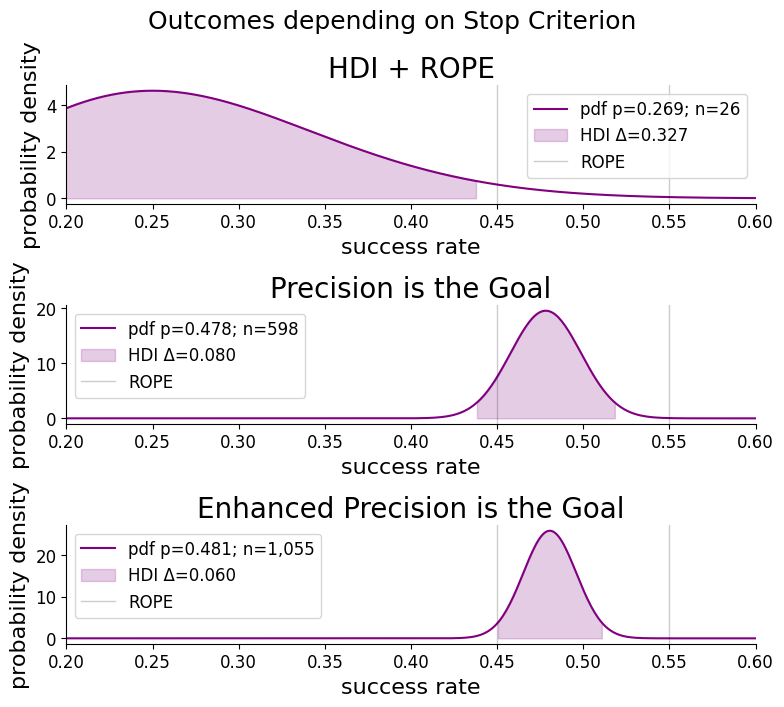

In [291]:

sr_experiment_stats_hdirope = df_stats_hdirope.loc[isample]
sr_experiment_stats_pitg = df_stats_pitg.loc[isample]
sr_experiment_stats_epitg = df_stats_epitg.loc[isample]

fig, axs = plt.subplots(3, 1, figsize=(FIG_WIDTH, 1.2* FIG_HEIGHT))
xlim = (0.2, 0.6)
#xlim = (0.4,0.8)


plt.subplot(3, 1, 1)
plot_pdf(sr_experiment_stats_hdirope, xlim=xlim)
plt.title("HDI + ROPE")

plt.subplot(3, 1, 2)
plot_pdf(sr_experiment_stats_pitg, xlim=xlim)
plt.title("Precision is the Goal")

plt.subplot(3, 1, 3)
plt.title("Enhanced Precision is the Goal")
plot_pdf(sr_experiment_stats_epitg, xlim=xlim)
plt.suptitle(f"Outcomes depending on Stop Criterion", fontsize=18)
plt.tight_layout()

In [ ]:
"""
    iteration_successes = sample.cumsum()
    iteration_failures = iteration_number - iteration_successes

    for iteration, successes, failures in zip(iteration_number, iteration_successes, iteration_failures):
        final_iteration = iteration == iteration_number[-1]
        hdi_min, hdi_max = successes_failures_to_hdi_limits(successes, failures)
        #hdi_min, hdi_max = successes_failures_caculate_hdi_limits(successes, failures)

        # has the precision goal been achieved?
        precision_goal_achieved = (hdi_max - hdi_min) < precision_goal

        # is the HDI conclusively within or outside the ROPE?
        decision_accept = (hdi_min >= rope_min) & (hdi_max <= rope_max)
        decision_reject_below = hdi_max < rope_min  
        decision_reject_above = rope_max < hdi_min
        conclusive = decision_accept | decision_reject_above | decision_reject_below
"""

In [ ]:
(df_stats_hdirope["reject_above"] | df_stats_hdirope["reject_below"]).sum() / len(df_stats_hdirope)

In [ ]:
(df_stats_pitg["reject_above"] | df_stats_pitg["reject_below"]).sum() / len(df_stats_pitg)

In [ ]:
(df_stats_epitg["reject_above"] | df_stats_epitg["reject_below"]).sum() / len(df_stats_epitg)

In [ ]:
df_stats_pitg["decision_iteration"].min(), df_stats_pitg["decision_iteration"].max()

In [ ]:
df_stats_pitg["inconclusive"].value_counts(normalize=True, dropna=False)  

In [ ]:
df_stats_epitg["inconclusive"].value_counts(normalize=True, dropna=False)  

In [ ]:
df_stats_pitg["success_rate"].mean(), df_stats_pitg["success_rate"].std()

In [ ]:
df_stats_epitg["success_rate"].mean(), df_stats_epitg["success_rate"].std()

In [ ]:
variances = []
hdi_widths = []
ns_ = []

for a_, b_ in dict_successes_failures_hdi_limits.keys():
    if a_ >= 10 and b_ >= 10:
        variances.append(beta.var(a_, b_))
        hdi_min, hdi_max = dict_successes_failures_hdi_limits[(a_, b_)]
        hdi_widths.append(hdi_max - hdi_min)
        ns_.append(a_ + b_)

In [ ]:
variances = np.array(variances)
hdi_widths = np.array(hdi_widths)
ns_ = np.array(ns_)

In [ ]:
plt.plot(variances, hdi_widths, marker="o", linestyle="none")

In [ ]:
plt.scatter(hdi_widths, hdi_widths/variances)

In [ ]:
plt.scatter(ns_, variances)
plt.scatter(ns_, hdi_widths)

# Precision and Risk as Goals

In [ ]:
idx = df_stats_pitg.index[0]

# ---
sr_experiment_stats_pitg = df_stats_pitg.loc[idx]
sr_experiment_stats_epitg = df_stats_epitg.loc[idx]

fig, axs = plt.subplots(2, 1, figsize=(FIG_WIDTH, FIG_HEIGHT))

plt.subplot(2, 1, 1)
plot_pdf(sr_experiment_stats_pitg) #, xlim=(0.4,1))
plt.title("Precision is the Goal")

plt.subplot(2, 1, 2)
plt.title("Enhanced Precision is the Goal")
plot_pdf(sr_experiment_stats_epitg) #, xlim=(0.4,1))
plt.tight_layout()

In [ ]:
sr_experiment_stats_pitg

In [ ]:
def pdf_area(pdf, dpp):
    return np.sum(pdf) * dpp

sr_experiment_stats = sr_experiment_stats_pitg.copy()

dpp = 0.0001
npp = int(1./dpp)
pp = np.linspace(0., 1., npp)

successes = sr_experiment_stats["successes"]
failures = sr_experiment_stats["failures"]
#rate = successes / (successes + failures)
#n_ = successes + failures

bool_in_rope = (rope_min <= pp) & (pp <= rope_max)
p_in_rope = pdf_area(pdf[bool_in_rope], dpp)

pdf = beta.pdf(pp, successes, failures)

plt.plot(pp,pdf, color="purple")
plt.fill_between(pp, pdf, where=bool_in_rope, alpha=0.2, color="orange")
plot_vhlines_lines(vertical=rope_min, label='ROPE', horizontal=None)
plot_vhlines_lines(vertical=rope_max, horizontal=None)

plt.xlim([rope_min - 0.1, rope_max + 0.1])

In [ ]:
pdf_area(pdf, dpp)

In [ ]:
df_stats_pitg.head(2)

In [ ]:
df_stats_pitg["in_rope"] = df_stats_pitg.apply(lambda x: pdf_area(beta.pdf(pp, x["successes"], x["failures"])[bool_in_rope], dpp) , axis=1)

In [ ]:
df_stats_epitg["in_rope"] = df_stats_epitg.apply(lambda x: pdf_area(beta.pdf(pp, x["successes"], x["failures"])[bool_in_rope], dpp) , axis=1)

In [ ]:
df_stats_pitg["in_rope"].describe()

In [ ]:
df_stats_pitg.query("inconclusive").shape

In [ ]:
(df_pitg_plot["in_rope"] > 1- fpr).sum() / len(df_pitg_plot)

In [ ]:
fpr = 0.05

df_pitg_plot = df_stats_pitg.query("inconclusive")

df_epitg_plot = df_stats_epitg.loc[df_pitg_plot.index]

plt.scatter(df_pitg_plot["decision_iteration"], df_pitg_plot["in_rope"], alpha=0.5, color="orange", label="PitG", marker=".")
#plt.scatter(df_epitg_plot["decision_iteration"], df_epitg_plot["in_rope"], alpha=0.5, color="purple", label="ePitG", marker=".")
plt.xlabel("stop iteration")
plt.ylabel("probability in ROPE")
plot_vhlines_lines(vertical=None, label=None, horizontal=1. - fpr, alpha=0.7, linestyle="--")

In [ ]:
plt.scatter(df_pitg_plot["decision_iteration"], df_epitg_plot["decision_iteration"], alpha=0.5, color="orange", label="PitG", marker=".")

frac_ = len(df_pitg_plot) / len(df_stats_pitg)
plt.title(f"{len(df_pitg_plot):,} inconclusive experiments ({frac_:0.1%})")
plot_vhlines_lines(vertical=None, label=None, horizontal=df_pitg_plot["decision_iteration"].min(), alpha=0.7, linestyle="--")
plot_vhlines_lines(vertical=None, label=None, horizontal=df_pitg_plot["decision_iteration"].max(), alpha=0.7, linestyle="--")

In [ ]:
def plot_parity_line(ax=None):
    if ax is None:
        ax = plt.gca()

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [np.min([xlims[0], ylims[0]]), np.max([xlims[1], ylims[1]])]

    ax.plot(lims, lims, "k--", linewidth=1)

In [ ]:
plt.scatter(df_stats_pitg["decision_iteration"], df_stats_pitg["in_rope"], alpha=0.05, color="orange", label="PitG", marker=".")
plt.scatter(df_stats_epitg["decision_iteration"], df_stats_epitg["in_rope"], alpha=0.05, color="purple", label="ePitG", marker=".")
plt.xlabel("stop iteration")
plt.ylabel("probability in ROPE")

In [ ]:
plt.hist(df_stats_pitg["in_rope"])
plt.hist(df_stats_epitg["in_rope"])

In [ ]:
df_stats_pitg.head(4).apply(lambda x: pdf_area(beta.pdf(pp, x["successes"], x["failures"]), dpp))

In [ ]:
pdf.sum() *dpp

In [ ]:
pdf